### Import Required Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

### Import the Data

In [2]:
df = pd.read_csv('amazon_alexa.tsv',delimiter='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


### Basic Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
df.duplicated().sum()

715

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df[df.verified_reviews.isna()]

,rating,date,variation,verified_reviews,feedback
473,2,2018-06-29,White,NaN,0


In [9]:
df.dropna(inplace=True)

## Analysis

### Rating

In [10]:
df.rating.value_counts(normalize=True)*100

rating
5    72.144618
4    14.174199
1     5.792933
3     4.642564
2     3.245686
Name: proportion, dtype: float64

<Axes: ylabel='count'>

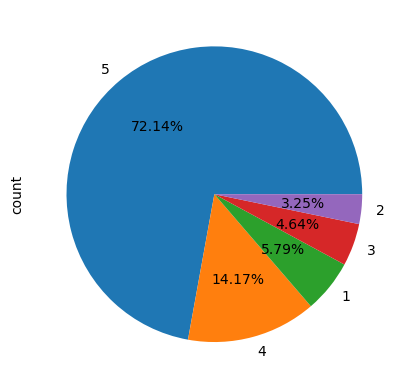

In [11]:
df.rating.value_counts().plot(kind='pie',autopct='%.2f%%')

### Date

In [12]:
df.date.describe()

count                             2434
mean     2018-07-22 11:06:45.258833152
min                2018-05-16 00:00:00
25%                2018-07-25 00:00:00
50%                2018-07-29 00:00:00
75%                2018-07-30 00:00:00
max                2018-07-31 00:00:00
Name: date, dtype: object

### Variation

In [13]:
df.variation.value_counts()

variation
Configuration: Fire TV Stick    342
Black  Plus                     270
Black                           261
Black  Show                     260
Black  Dot                      252
Black  Spot                     241
Charcoal Fabric                 219
White  Spot                     108
White  Dot                       92
White                            90
White  Show                      85
Heather Gray Fabric              79
White  Plus                      78
Sandstone Fabric                 45
Oak Finish                        7
Walnut Finish                     5
Name: count, dtype: int64

### Feedback

In [14]:
df.feedback.value_counts()

# Target Variable
#  1 - Positive
#  0 - Negative

feedback
1    2214
0     220
Name: count, dtype: int64

In [15]:
df.feedback.value_counts(normalize=True)*100

feedback
1    90.96138
0     9.03862
Name: proportion, dtype: float64

In [16]:
df[df.feedback==0]['rating'].value_counts()

rating
1    141
2     79
Name: count, dtype: int64

In [17]:
df[df.feedback==1]['rating'].value_counts()

rating
5    1756
4     345
3     113
Name: count, dtype: int64

### Verified Reviews

In [18]:
df['Length'] = df.verified_reviews.apply(len)

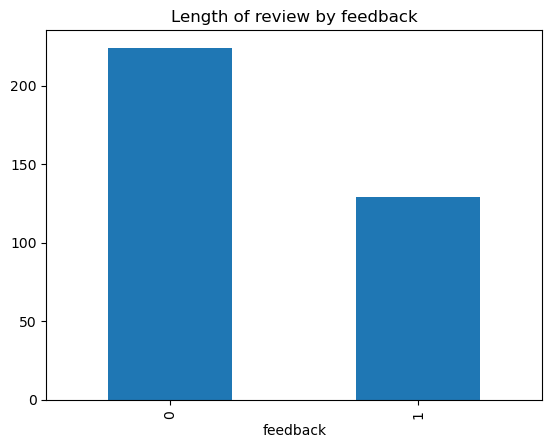

In [19]:
df.groupby('feedback')['Length'].mean().plot(kind='bar')
plt.title('Length of review by feedback')
plt.show()

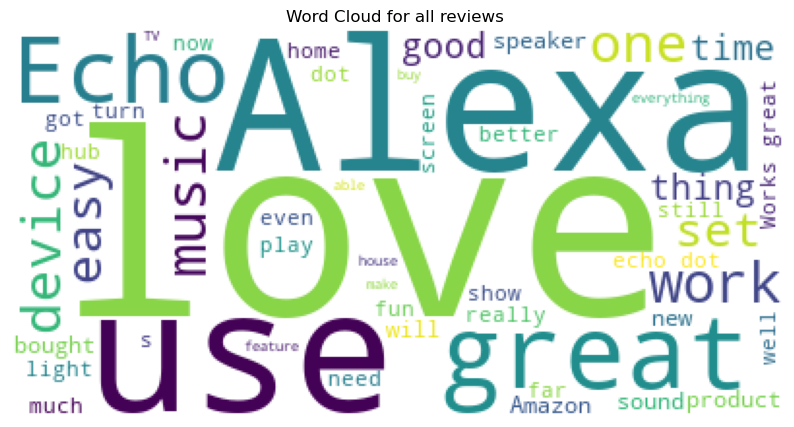

In [20]:
from wordcloud import WordCloud

reviews = ' '.join([i for i in df.verified_reviews])

wc = WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Word Cloud for all reviews ')
plt.axis('off')
plt.show()

In [21]:
neg_review = ' '.join(i for i in df[df.feedback == 0]['verified_reviews'])
neg_review = neg_review.lower().split()

pos_review = ' '.join(i for i in df[df.feedback == 1]['verified_reviews'])
pos_review = pos_review.lower().split()

neg_unique = [i for i in neg_review if i not in pos_review]
neg_unique = ' '.join(neg_unique)

pos_unique = [i for i in pos_review if i not in neg_review]
pos_unique = ' '.join(pos_unique)

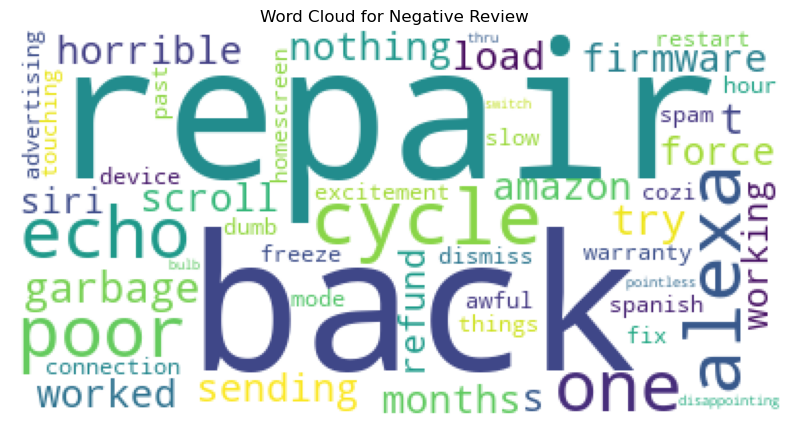

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(neg_unique))
plt.title('Word Cloud for Negative Review ')
plt.axis('off')
plt.show()

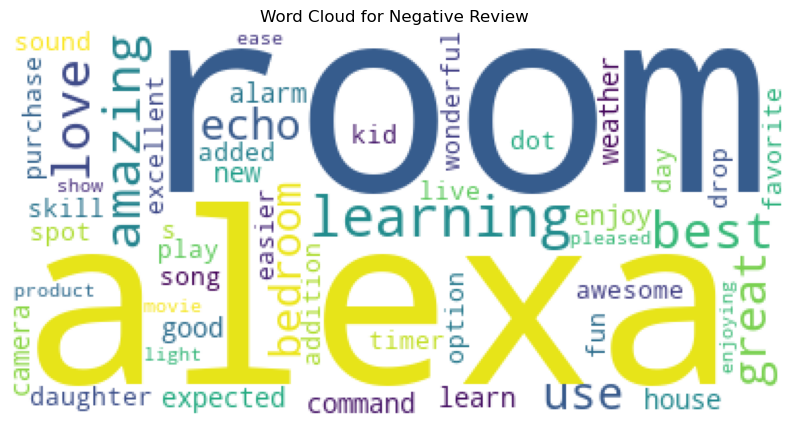

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(pos_unique))
plt.title('Word Cloud for Negative Review ')
plt.axis('off')
plt.show()

## Preprocessing

To build the corpus from the verified reviews, we perform the following -

1. Replace any non alphabet characters with a space
2. Convert to lower and split the words
3. Iterate over the individual words and if not in stopwords then add the stemmed form of word to the corpus

In [24]:
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

In [25]:
import re
from nltk.stem.porter import PorterStemmer

In [26]:
corpus = []
ps = PorterStemmer()

for i in range(0,df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ',df.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [ps.stem(j) for j in review if not j in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=2500)

x = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

### Train Test Split

In [29]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.7,random_state=10)

### Model Building

In [41]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
rf.fit(xtrain,ytrain)
ypred = rf.predict(xtest)

print('Training Accuracy: ', rf.score(xtrain,ytrain))
print('Testing Accuracy: ', rf.score(xtest,ytest))

Training Accuracy:  0.9759248385202584
Testing Accuracy:  0.9124487004103967
